# 1D Advection-Diffusion problem

## General formulation

This is a well known problem to FEM with Continuous Galerkin approximation. Spurious oscillations rise when certain (not rare) conditions are met. The general problem consists in:

Find $u \in \mathbb{C}^2$ such that:

\begin{equation}
\left\{
\begin{aligned}
- &k \Delta u + \mathbf{b}\cdot \nabla u = f(x), \quad \forall x \in (\Omega \subset \mathbb{R}^n) \\
&\left. u \right|_{\partial \Omega} = g(x)
\end{aligned}
\right.
\end{equation}
where $\overline{\Omega} := \Omega \cup \partial \Omega$ denotes the closed domain, $\Omega$ is the open domain and $\partial \Omega$ is the domain's boundary (the closure). Note that $\Omega \cap \partial \Omega = \emptyset$. The solution is a scalar field such that $u: \Omega \to \mathbb{R}$. Also, we have the "source term" that is a scalar field of the same form, $f: \Omega \to \mathbb{R}$, but this function is a given data to the (direct) problem. The $g(x)$ is a prescribed function applied to the boundary, which is also a given data to the problem. The parameter $k$ (here a scalar field like $u$) sometimes is named as "diffusivity coefficient" related to the quantity $u$, in a physical context (transport of a quantity, look for Reynolds' Theorem for further clarifications). In some contexts, parameter $k$ must be a 2-rank tensor, as in anisotropic Porous Media flows. Analagously, we have the parameter $\mathbf{b}: \Omega \to \mathbb{R}^n$ (a vector field), which is denoted as the "advective velocity" related to the medium velocity where $u$ is been transport. Parameters $k$ and $\mathbf{b}$ are given data to the (direct) problem too.


P.S.: I will not discuss the ill problems formulation, neither others mathematical requirements to assert the well-posedness of the problem, uniqueness and so on.

## 1D simplification

In some scenarios, the mathematical modeling approach can be simplified to the 1D case, which is written as follows:

Find $u \in \mathbb{C}^2$ such that:

\begin{equation}
\left\{
\begin{aligned}
- &k\frac{d^2 u}{d x^2} + b \frac{d u}{d x} = f(x), \quad \forall x \in ((x_1, x_2) \subset \mathbb{R}) \\
&u(x_1) = u_1 \\
&u(x_2) = u_2
\end{aligned}
\right.
\end{equation}

where $u_1, u_2 \in \mathbb{R}$ are the prescribed boundary condition values. Such problems are known as Two-Point Boundary Value problems.

### Variational formulation and Galerkin approximation

One can find the derivation of the weak form, but I will just give its result below.

Given the space of admissible solution:

\begin{equation}
\mathcal{U} (\Omega) := \left\{ u \in H^1 (\Omega) \left| \,u(x_1) = u_1, u(x_2) = u_2 \right. \right\}
\end{equation}

and the space of suitable variations as

\begin{equation}
\mathcal{V} (\Omega) := \left\{ v \in H^1 (\Omega) \left| \,u(x_1) = u(x_2) = 0 \right. \right\}
\end{equation}

The discretization of the above spaces is performed by Galerkin approximation with Lagrangean function space of order $k$. Thus we define here:

\begin{equation}
            \mathcal{S}_h^k := \left\{ \varphi_h \in \mathcal{C}(\Omega^e): \left.\varphi\right|_{\Omega^e} 
            \in \mathbb{P}_k(\Omega^e), \forall \Omega^e \in \mathcal{T}_h \right\}
\end{equation}

the space of Lagrange polynomials subject to a domain partition $\mathcal{T}_h:=\cup \Omega^e \approx \overline{\Omega}$ and $\cap \Omega^e = \emptyset$ (non-overlapping elements). Thus

\begin{equation}
    \mathcal{U}_h := \mathcal{U} \cap \mathcal{S}_h^k \quad \text{and} \quad
    \mathcal{V}_h := \mathcal{V} \cap \mathcal{S}_h^k
\end{equation}

we have the discretized spaces.

Now, we can stated out our "discretized" Variational Formulation as:

Find $u_h \in \mathcal{U}_h$ such that

\begin{equation}
a(u_h, v_h) = F(v_h), \quad \forall v_h \in \mathcal{V}_h
\end{equation}

where

\begin{align}
a(u, v) &:= \int_{\Omega} \frac{d u}{d x} \frac{d v}{d x} dx
          + \int_{\Omega} b \frac{d u}{d x} v dx\\
F(v) &:= \int_{\Omega} f v dx
\end{align}

and the domain is $\overline{\Omega} \equiv [x_1, x_2]$.

## A practical FEniCS example

Solve this in FEniCS is very straightforward compared to classical FEM codes. The FEniCS framework provides a high-level interface which eases the pain at most.

Just for learning purpose, let the given data be setted as:

\begin{align}
&f(x) \equiv f = 1 \\
&u_1 = u_2 = 0 \\
&x_1 = 0, &x_2 = 1 \\
&k = 10^{-8}, &a = 1 
\end{align}

With the source term as $f(x) = 1$, the exact solution can be easily obtained:

\begin{equation}
u(x) \approx
\left\{ 
\begin{aligned}
&u(x) = x, &\text{if } x \in [x_1, x_2) \\
&u(x) = 0, &\text{if } x = x_2
\end{aligned}
\right.
\end{equation}

for small values of $k$, say $k = 10^{-8}$.

So, how to solve the problem with FEniCS? We will construct the procedures stepwisely.

* Importing all the libs we'll need. 

In [1]:
from fenics import *  # all the FEniCS namespace (not a recommended Python practice)
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

* Defining the domain and related mesh

In [2]:
x_left = 0.0
x_right = 1.0
numel = 15
mesh = IntervalMesh(numel, x_left, x_right)  # IntervalMesh(num_of_elements, inf_interval, sup_interval)
mesh_ref = IntervalMesh(100, x_left, x_right)

* Setting the degree of the functions in the Continuous Galerkin method and the variation space. Additionaly, we define here a space to be employed in the projection of the reference analytical solution

In [3]:
p = 1
V = FunctionSpace(mesh, "CG", p)  # "CG" stands for Continuous Galerkin, p is the degree
Vref = FunctionSpace(mesh_ref, "CG", p)

* Defining a Python function which marks the boundaries

In [4]:
def left(x, on_boundary):
    return x < 0+DOLFIN_EPS
def right(x, on_boundary):
    return x > 1-DOLFIN_EPS

* Setting the prescribed boundary values

In [5]:
u1, u2 = 0.0, 0.0
g_left = Constant(u1)
g_right = Constant(u2)

* Now we modify the spaces, as expected

In [6]:
bc_left = DirichletBC(V, g_left, left)
bc_right = DirichletBC(V, g_right, right)
dirichlet_condition = [bc_left, bc_right]

* Here we define the source function over the domain

In [7]:
f = Constant(1)

* Now comes the good part. We set up the Trial and Test functions from the admissible space

In [8]:
u_h = TrialFunction(V)
v_h = TestFunction(V)

* The parameters of the problem

In [9]:
k = Constant(1e-8)
b = Constant(1.0)

* Then we write the unsymmetric form, very much like it is written in mathematical form

In [10]:
a = k*inner(grad(v_h), grad(u_h))*dx + b*inner(grad(u_h)[0], v_h)*dx

* Also we define the associated linear form

In [11]:
L = f*v_h*dx

* Now we declare the solution variable

In [12]:
u_sol = Function(V)

* Thus we set the discretized variational problem to be solved

In [13]:
problem = LinearVariationalProblem(a, L, u_sol, dirichlet_condition)

* And we go further and solve it with no difficulties!

In [14]:
solver = LinearVariationalSolver(problem)
solver.solve()

* But we will need to check if the solution is "good enough". So we compare with the available exact solution

In [15]:
sol_exact = Expression(
    'x[0]<=0+tol || x[0]>=1 / b - tol ? 0 : x[0]', 
    degree=1,
    b=b,
    tol=DOLFIN_EPS
)
u_e = interpolate(sol_exact, Vref)
u_e = interpolate(sol_exact, Vref)

* Now, lets plot our results!

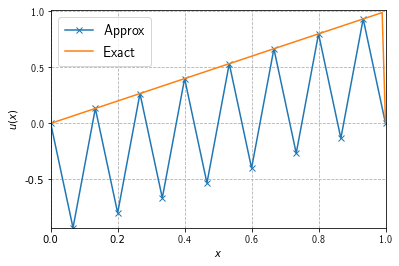

In [16]:
plot(u_sol, marker='x', label='Approx')
plot(u_e, label='Exact')
# Setting the font
plt.rc('text',usetex=True)
plt.rc('font', size=14)
# Plotting
plt.xlim(x_left, x_right)   # Limites do eixo x
plt.ylim(np.min(u_sol.vector().get_local()), 1.02*np.max(u_e.vector().get_local()))  # Limites do eixo y
plt.grid(True, linestyle='--')  # Ativa o grid do grafico
plt.xlabel(r'$x$')  # Legenda do eixo x
plt.ylabel(r'$u(x)$')   # Legenda do eixo y
plt.legend(loc='best',borderpad=0.5)    # Ativa legenda no grafico e diz para se posicionar na melhor localizacao detectada
plt.show()  # Exibe o grafico em tela

## Something seems not good...

Terrible, it isn't? This is due the high Péclet number of the problem. The Péclet number is conceptually defined as

\begin{equation}
Pe := \frac{\text{advection rate of a physical quantity}}{\text{diffusion rate of a physical quantity}}
\end{equation}

In Finite Element context, we evaluate the Péclet number in an element-wise manner, because this is how we (normally) stabilize the method and vanish the spurious oscillations. The local (within each element) Péclet number is denote as

\begin{equation}
Pe_K := \frac{m_k \left|\mathbf{b}\right|_p h_k}{2k}
\end{equation}

where $\left|\bullet\right|_p$ denote the lenght in terms of the p-dimensional euclidian norm. The $m_k$ parameter comes from the error analysis. One can check a summarized analysis in the paper "Revisiting stabilized finite element methods for the advective–diffusive equation" (Franca et. al, 2006). Highly recommended reading, by the way. But I can antecipate that

\begin{align}
&m_k := \min \left\{ \frac{1}{3}, 2C_k \right\} \\
&C_k\sum_{K} h_K^2 ||\Delta v||^2_{0,K} \leq ||\nabla v ||^2_0, \quad \forall v \in V_h
\end{align}

where $h_K$ is the mesh parameter, related to some characteristic lenght of the element. In 1D elements, it is just the size of the element. For our purpose (1D), we can assume $m_k = \dfrac{1}{3}$.

So, where all this stuff will be used?

## SUPG stabilization

A very commom, and one of the most employed even nowaday, is the Streamline Upwind Petrov-Galerkin stabilization. It follows the idea used in finite difference method of using an upwind term, interpreted as an artifficial diffusion, which is added to the Variational problem. Didn't read Franca et. al (2006) yet?!

With the modification, the variational problem is rewritten as follows:

\begin{equation}
B(u,v) = F(v)
\end{equation}

and

\begin{align}
&B(u,v) := a(u,v) + R(u,v) \\
&F(v) := L(v) + S(v)
\end{align}

with

\begin{align}
&R(u,v) := \sum_{K}\tau_k \left(-k \Delta u + \mathbf{b}\cdot \nabla u, \mathbf{b}\cdot \nabla v  \right)_K \\
&S(v) := \sum_{K}\tau_k \left(f, \mathbf{b}\cdot \nabla v  \right)_K
\end{align}

where

\begin{equation}
(u, v)_{K} := \int_{\Omega^K} u v dx
\end{equation}

denotes the function inner product restricted to the element $K$.

Note the presence of a stabilizing parameter $\tau_k$. By this parameter, we control how much we want to add to an element local contribution aiming to stabilize in the local formulation. This parameter is computed locally as follows (see Franca et. al, I insist):

\begin{equation}
\tau_K := \frac{h_K}{2|a|_P} \xi(Pe_K)
\end{equation}

where

\begin{equation}
\xi(Pe_K) :=
\left\{
\begin{aligned}
&Pe_K, &0\leq Pe_K < 1 \\
&1, &Pe_K \geq 1
\end{aligned}
\right.
\end{equation}

As a remark, I would like to say that there is SEVERAL ways to define and derive stabilizing parameters. The approach provided above is described by Franca et. al (2006). Nonetheless, the FEM stabilization methods is a very active research area even today, so one can find several stabilizing parameters elsewhere.

### 1D SUPG

To simplify to 1D, just remember that the gradient reduce to $\nabla (\bullet) \equiv \dfrac{d (\bullet)}{d x}$. Thus,

\begin{align}
&R(u,v) := \sum_{K}\tau_k \left(-k \frac{d^2 u}{d x^2} + b\frac{d u}{d x}, b\frac{d v}{d x}  \right)_K \\
&S(v) := \sum_{K}\tau_k \left(f, b\frac{d v}{d x}  \right)_K
\end{align}

## Revisiting the FEniCS implementation

Finally, we can stabilize with SUPG the previous Continuous Galerkin FEM approach.

* First, we need to define the stabilizing parameter and its related quantities

In [17]:
m_k = 1.0/3.0
h_k = CellDiameter(mesh) # Mesh parameter
b_norm = abs(b)
Pe_k = m_k*b_norm*h_k/(2.0*k)
one = Constant(1.0)
eps_k = conditional(gt(Pe_k,one), one, Pe_k)
tau_k = h_k/(2.0*b_norm)*eps_k

* Now we add the stabilizing terms to the classical Galerkin formulation

In [18]:
a += inner((b*grad(u_h)[0] - k*div(grad(u_h))), tau_k*b*grad(v_h)[0])*dx
L += f*tau_k*b*grad(v_h)[0]*dx

* Redefining the problem

In [19]:
u_sol = Function(V)
problem = LinearVariationalProblem(a, L, u_sol, dirichlet_condition)

* Solving the stabilized problem

In [20]:
solver = LinearVariationalSolver(problem)
solver.solve()

* Now we plot the results to check

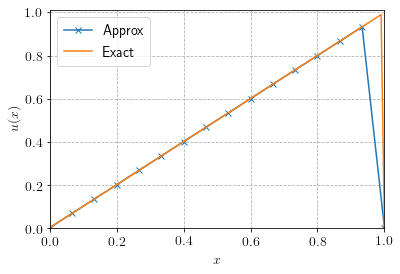

In [21]:
plot(u_sol, marker='x', label='Approx')
plot(u_e, label='Exact')
# Configuracoes de fontes no grafico
plt.rc('text',usetex=True)
plt.rc('font', size=14)
# Plotando
plt.xlim(x_left, x_right)   # Limites do eixo x
plt.ylim(np.min(u_sol.vector().get_local()), 1.02*np.max(u_e.vector().get_local()))  # Limites do eixo y
plt.grid(True, linestyle='--')  # Ativa o grid do grafico
plt.xlabel(r'$x$')  # Legenda do eixo x
plt.ylabel(r'$u(x)$')   # Legenda do eixo y
plt.legend(loc='best',borderpad=0.5)    # Ativa legenda no grafico e diz para se posicionar na melhor localizacao detectada
plt.show()  # Exibe o grafico em tela

Now things look right.

## Another stabilization: Galerkin Least Squares (GLS)

An alternative stabilization is the very well known method named Galerkin Least Squares, or GLS for short.
This methods was introduced by Hughes, Franca and Hulbert (see the paper "A new finite element formulation for computational fluid dynamics: VIII. The Galerkin/least-squares method for advective–diffusive equations" for further details).

It's very similar to SUPG method in the modification sense related to the classical Galerkin formulation. Now, we have the following terms to add:

\begin{align}
&R_{GLS}(u,v) := \sum_{K}\tau_k \left(-k \Delta u + \mathbf{b}\cdot \nabla u, \mathbf{b}\cdot \nabla v - k \Delta v \right)_K \\
&S_{GLS}(v) := \sum_{K}\tau_k \left(f, \mathbf{b}\cdot \nabla v - k \Delta v  \right)_K
\end{align}

which trivially is extended to 1D as

\begin{align}
&R_{GLS}(u,v) := \sum_{K}\tau_k \left(-k \frac{d^2 u}{d x^2} + b\frac{d u}{d x}, b\frac{d v}{d x} -k \frac{d^2 v}{d x^2}  \right)_K \\
&S_{GLS}(v) := \sum_{K}\tau_k \left(f, b\frac{d v}{d x} -k \frac{d^2 u}{d x^2}  \right)_K
\end{align}

Note that for linear elements, better saying, for those with linear shape functions, the formulation of SUPG and GLS are the same, because $\Delta v = 0$.

### 1D GLS implementation in FEniCS

The stabilization parameter and its parameters can be pretty much the same as in SUPG. Minor changes are necessary, but we will solve within a different variational problem just to compare the methods.

* The classical Continuous Galerkin terms

In [22]:
a_GLS = k*inner(grad(v_h), grad(u_h))*dx + b*inner(grad(u_h)[0], v_h)*dx
L_GLS = f*v_h*dx

* Adding the GLS terms

In [23]:
a_GLS += inner((b*grad(u_h)[0] - k*div(grad(u_h))), tau_k*b*grad(v_h)[0] - k*div(grad(v_h)))*dx
L_GLS += tau_k*b*inner(f, grad(v_h)[0] - k*div(grad(v_h)))*dx

* Now we solve the problem with GLS

In [24]:
u_sol_gls = Function(V)
problem = LinearVariationalProblem(a_GLS, L_GLS, u_sol_gls, dirichlet_condition)
solver = LinearVariationalSolver(problem)
solver.solve()

* Then we plot:

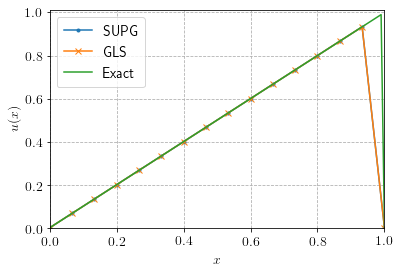

In [25]:
plot(u_sol, marker='.', label='SUPG')
plot(u_sol_gls, marker='x', label='GLS')
plot(u_e, label='Exact')
# Configuracoes de fontes no grafico
plt.rc('text',usetex=True)
plt.rc('font', size=14)
# Plotando
plt.xlim(x_left, x_right)   # Limites do eixo x
plt.ylim(np.min(u_sol.vector().get_local()), 1.02*np.max(u_e.vector().get_local()))  # Limites do eixo y
plt.grid(True, linestyle='--')  # Ativa o grid do grafico
plt.xlabel(r'$x$')  # Legenda do eixo x
plt.ylabel(r'$u(x)$')   # Legenda do eixo y
plt.legend(loc='best',borderpad=0.5)    # Ativa legenda no grafico e diz para se posicionar na melhor localizacao detectada
plt.show()  # Exibe o grafico em tela

The above result confirms what we expected: Same result to linear polynomials $p = 1$.